Links:
 - https://en.wikipedia.org/wiki/Spherical_geometry
 - https://en.wikipedia.org/wiki/List_of_map_projections
 - https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm
 - https://en.wikipedia.org/wiki/Xiaolin_Wu's_line_algorithm
 - https://brsr.github.io/2021/05/01/vector-spherical-geometry.html

In [ ]:
# Old

# def great_circle_distance(lat_0, lon_0, lat_1, lon_1, radius = 1):
#     if (lat_0 != lat_1) or (lon_0 != lon_1):
#         a = np.sin((lat_1 - lat_0)/2)**2 + np.cos(lat_0)*np.cos(lat_1)*np.sin((lon_1 - lon_0)/2)**2
#         c = 2*np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#         return radius*c
#         # return radius*np.arccos(np.sin(lat_0)*np.sin(lat_1) + np.cos(lat_0)*np.cos(lat_1)*np.cos(lon_0 - lon_1))
#     else:
#         return 0

# def great_circle_angle(lat_0, lon_0, lat_1, lon_1):
#     x_0, y_0, z_0 = spherical_to_cartesian(lat_0, lon_0)
#     x_1, y_1, z_1 = spherical_to_cartesian(lat_1, lon_1)
#     vector = np.array([x_1 - x_0, y_1 - y_0, z_1 - z_0]) # Vector from point 0 to point 1
#     vector_ref = np.array([0, 0, 1]) # Reference vector from origin to north pole
#     vector_ortho = np.array([x_0, y_0, z_0]) # Vector from the origin to point 0, defining a plane tangent to the sphere at point 0
#     vector_proj = vector - (np.dot(vector, vector_ortho)/np.linalg.norm(vector_ortho)**2)*vector_ortho # The projection of vector onto the plane, i.e. the tangent to the sphere at point 0 directed towards point 1
#     if not np.isclose(vector_proj, np.zeros((3))).all():
#         # return np.arccos(np.dot(vector_ref, vector_proj)/(np.linalg.norm(vector_ref)*np.linalg.norm(vector_proj)))
#         return np.pi/2 + np.arctan2(vector_proj[1], vector_proj[0]) - np.arctan2(vector_ref[1], vector_ref[0])
#     else:
#         return np.pi/2

# def dis(lat_0, lon_0, lat_1, lon_1):
#     return np.arccos(np.sin(lat_0)*np.sin(lat_1) + np.cos(lat_0)*np.cos(lat_1)*np.cos(lon_0 - lon_1))

# def ang(lat_0, lon_0, lat_1, lon_1):
#     angle = np.arccos(np.cos(dis(lat_1, lon_1, lat_0, lon_0 + np.pi/2))/np.sin(dis(lat_0, lon_0, lat_1, lon_1)))
#     if lat_1 >= lat_0:
#         return angle
#     elif lat_1 < lat_0:
#         return 2*np.pi - angle
    
# u = (0, 0)
# v = (u[0], u[1] + np.pi/2) # reference
# w = (-np.pi/4, np.pi)
# a = dis(*u, *v)# np.pi/2 # length of reference
# b = dis(*u, *w)
# c = dis(*w, *v)
# if w[0] >= u[0]:
#     c_angle = np.arccos((np.cos(c) - np.cos(a)*np.cos(b))/(np.sin(a)*np.sin(b)))
# elif w[0] < u[0]:
#     c_angle = 2*np.pi - np.arccos((np.cos(c) - np.cos(a)*np.cos(b))/(np.sin(a)*np.sin(b)))
# print(a)
# print(b)
# print(c)
# print(np.degrees(c_angle))
# print(np.degrees(ang(*u, *w)))

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def spherical_to_cartesian(lat, lon, rad = 1):
    x = rad*np.sin(lat)*np.cos(lon)
    y = rad*np.sin(lat)*np.sin(lon)
    z = rad*np.cos(lat)
    return x, y, z

def points_around_sphere(shape):
    polar_points, equitorial_points = shape
    equitorial_radius = equitorial_points/np.pi
    circle_diameter = equitorial_radius*np.sin(np.linspace(0, np.pi, polar_points))
    circle_circumference = np.pi*circle_diameter
    number_points = np.around(circle_circumference).astype(int)
    number_points[number_points == 0] = 1
    return number_points

def great_circle_distance(lat_0, lon_0, lat_1, lon_1): # Why do lat and lon need to be swapped for this to work?
    return np.arccos(np.sin(lat_0)*np.sin(lat_1) + np.cos(lat_0)*np.cos(lat_1)*np.cos(lon_0 - lon_1))

def great_circle_angle(lat_0, lon_0, lat_1, lon_1):
    # angle counterclockwise from north pole
    p_ref = (np.pi/2, 0)
    p_0 = (lat_0, lon_0)
    p_1 = (lat_1, lon_1)
    d_0_ref = great_circle_distance(*p_0, *p_ref)
    d_1_ref = great_circle_distance(*p_1, *p_ref)
    d_0_1 = great_circle_distance(*p_0, *p_1)
    arg = (np.cos(d_1_ref) - np.cos(d_0_ref)*np.cos(d_0_1))/(np.sin(d_0_ref)*np.sin(d_0_1))
    arg = np.where(arg < -1, -1, arg)
    arg = np.where(arg > 1, 1, arg)
    angle = np.arccos(arg)
    if lon_0 >= 0:
        condition = np.logical_or((lon_1 > lon_0), (lon_1 <= lon_0 - np.pi))
    elif lon_0 < 0:
        condition = np.logical_and((lon_1 > lon_0), (lon_1 <= lon_0 + np.pi))
    return np.where(condition, 2*np.pi - angle, angle) + np.pi/2

In [3]:
image_shape = (256, 512)
no_gridlines = (5, 5)
gridline_thickness = 2
no_plumes = 16
seed = 0

In [4]:
rng = np.random.default_rng(seed = seed)

# Calculate number of longitudinal samples for each latitude and define a mask
no_points = points_around_sphere(image_shape)
mask = np.zeros(image_shape, dtype = bool)
for points_index, points in enumerate(no_points):
    lower = np.floor(image_shape[1]/2 - points/2).astype(int)
    upper = np.ceil(image_shape[1]/2 + points/2).astype(int)
    mask[points_index, lower:upper] = True
mask = np.full(image_shape, True)

coordinates = np.zeros((2, *image_shape))
for column_index in range(image_shape[1]):
    column = coordinates[0, :, column_index]
    # column[mask[:, column_index]] = np.linspace(np.pi/2, -np.pi/2, mask[:, column_index].sum()) # linspace defined with no. elements equal to no. True pixels in mask for each row
    column[mask[:, column_index]] = np.linspace(-np.pi/2, np.pi/2, image_shape[0])[mask[:, column_index]] # linspace defined for entire row, but only subset of elements where row is True used
for row_index in range(image_shape[0]):
    row = coordinates[1, row_index, :]
    row[mask[row_index, :]] = np.linspace(-np.pi, np.pi, mask[row_index, :].sum())
    # row[mask[row_index, :]] = np.linspace(0, 2*np.pi, image_shape[1])[mask[row_index, :]]

lines_lat = np.linspace(-np.pi/2, np.pi/2, no_gridlines[0]) # coordinates of vertical (latitudinal) lines
lines_lon = np.linspace(-np.pi, np.pi, no_gridlines[1]) # coordinates of horizontal (longitudinal) lines
grid = np.full((2, *image_shape), False)
for column_index in range(image_shape[1]):
    for line in lines_lat:
        distances = np.where(mask[:, column_index], np.abs(coordinates[0, :, column_index] - line), np.nan) # Distance from each pixel in the given column to the current longitudinal line, excluding pixels outside mask
        row_indices = np.argpartition(distances, gridline_thickness)[:gridline_thickness] # Indices of the k shortest distances
        grid[0, row_indices, column_index] = True
for row_index in range(image_shape[0]):
    for line in lines_lon:
        distances = np.where(mask[row_index, :], np.abs(coordinates[1, row_index, :] - line), np.nan) # Distance from each pixel in the given row to the current latitudinal line, excluding pixels outside mask
        column_indices = np.argpartition(distances, gridline_thickness)[:gridline_thickness] # Indices of the k shortest distances
        grid[1, row_index, column_indices] = True

plumes = {"coordinates" : np.stack([rng.uniform(-np.pi/2, np.pi/2, no_plumes), rng.uniform(-np.pi, np.pi, no_plumes)], 1),
          "distance" : np.zeros((no_plumes, *image_shape)),
          "angle" : np.zeros((no_plumes, *image_shape)),
          "force" : np.zeros((no_plumes, 2, *image_shape)),
          "nearest" : np.zeros((no_plumes, *image_shape))}
for plume_index in range(no_plumes):
    plumes["distance"][plume_index] = np.where(mask, great_circle_distance(*plumes["coordinates"][plume_index], *coordinates), np.nan)
    plumes["angle"][plume_index] = np.where(mask, great_circle_angle(*plumes["coordinates"][plume_index], *coordinates), np.nan)
    force = np.where(mask, np.where(plumes["distance"][plume_index] != 0, plumes["distance"][plume_index]**-2, 0), np.nan)
    plumes["force"][plume_index] = force*np.stack([np.sin(plumes["angle"][plume_index]), np.cos(plumes["angle"][plume_index])])
for plume_index in range(no_plumes):
    plumes["nearest"][plume_index] = np.where(plumes["distance"].argmin(0) == plume_index, True, False)

point 0 is plume centre, point 1 is a given point on the sphere's surface

define the great circle passing through both points

use the acceleration field along this line to determine whether or not an object (newly formed crust) could have travelled from point 0 to point 1 in the given length of time


You should define force as a function of distance and angle for each plume, then you can just take the integral of this function along a great circle from point 0 to point 1 and us that to see if object could have reach 1 from 0

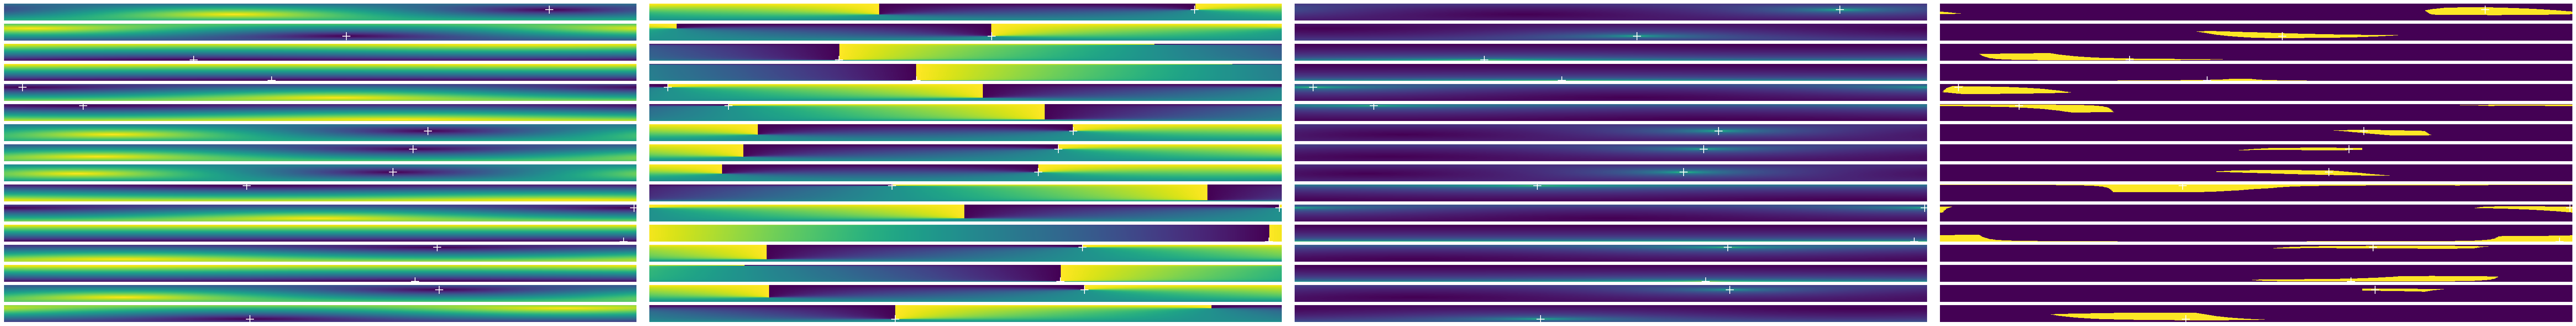

In [5]:
images = np.array([[plumes["distance"][plume_index],
                    plumes["angle"][plume_index],
                    np.log(np.linalg.norm(plumes["force"][plume_index], axis = 0)),
                    plumes["nearest"][plume_index]]
                   for plume_index in range(no_plumes)])
figure, axes = plt.subplots(images.shape[0], images.shape[1], figsize = (4*images.shape[0], 2*images.shape[1]), layout = "constrained")
for axis_index, axis in np.ndenumerate(axes):
    axis.pcolormesh(*coordinates[::-1], images[axis_index])
    axis.scatter(*plumes["coordinates"][axis_index[0]][::-1], s = 200, marker = "+", color = "white")
    axis.axis("off")

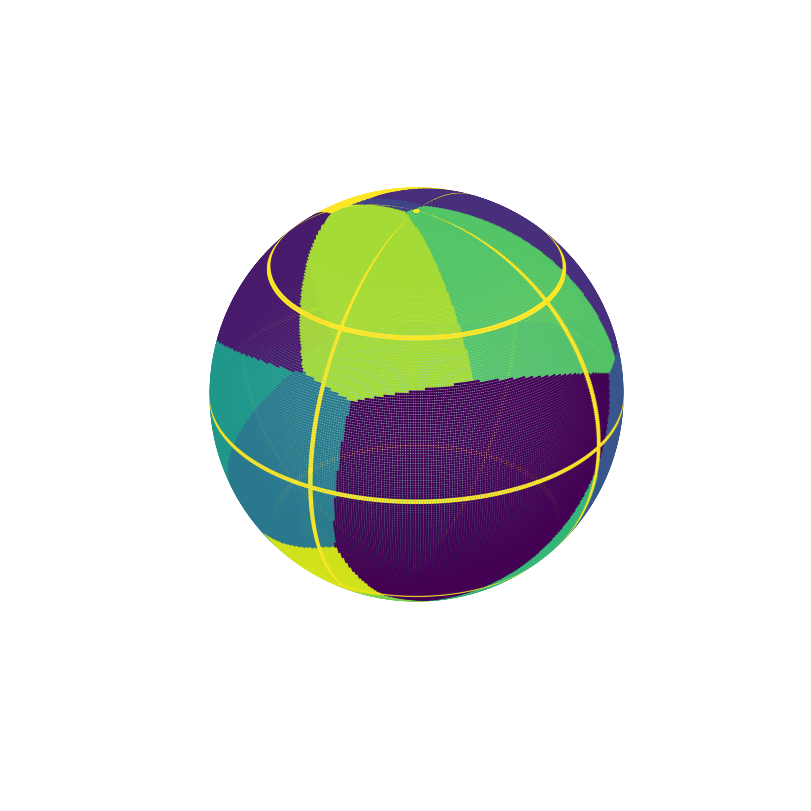

In [6]:
# surface = np.linalg.norm(plumes, axis = 1).sum(0)
# surface = plumes.sum(0)[1]
# surface = plumes[2, 1]
# surface = np.abs(plumes.sum(0)[0]) * np.abs(plumes.sum(0)[1])
# surface = (np.linalg.norm(plumes, axis = 1)/plumes_norm).max(0)
surface = np.array([(plume_index + 1)*plume for plume_index, plume in enumerate(plumes["nearest"])]).sum(0)
surface[grid.any(0)] = surface.max()
x, y, z = spherical_to_cartesian(coordinates[0] + np.pi/2, coordinates[1] + np.pi)
figure, axis = plt.subplots(1, 1, figsize = (8, 8), layout = "constrained", subplot_kw = {'projection': "3d"})
axis.scatter(x, y, z, c = surface, s = 1, norm = "linear")
# c = np.empty((*image_shape, 3), dtype = np.float64)
# for i in np.ndindex(image_shape):
#     c[i] = (surface[i], surface[i], surface[i])
# for i in range(3):
#     c[:, :, i] -= c[:, :, i].min()
#     c[:, :, i] /= c[:, :, i].max()
# axis.plot_surface(x, y, z, rstride = 1, cstride = 1, facecolors = c)
axis.axis("off")
axis.set_box_aspect((1, 1, 1))
plt.show()

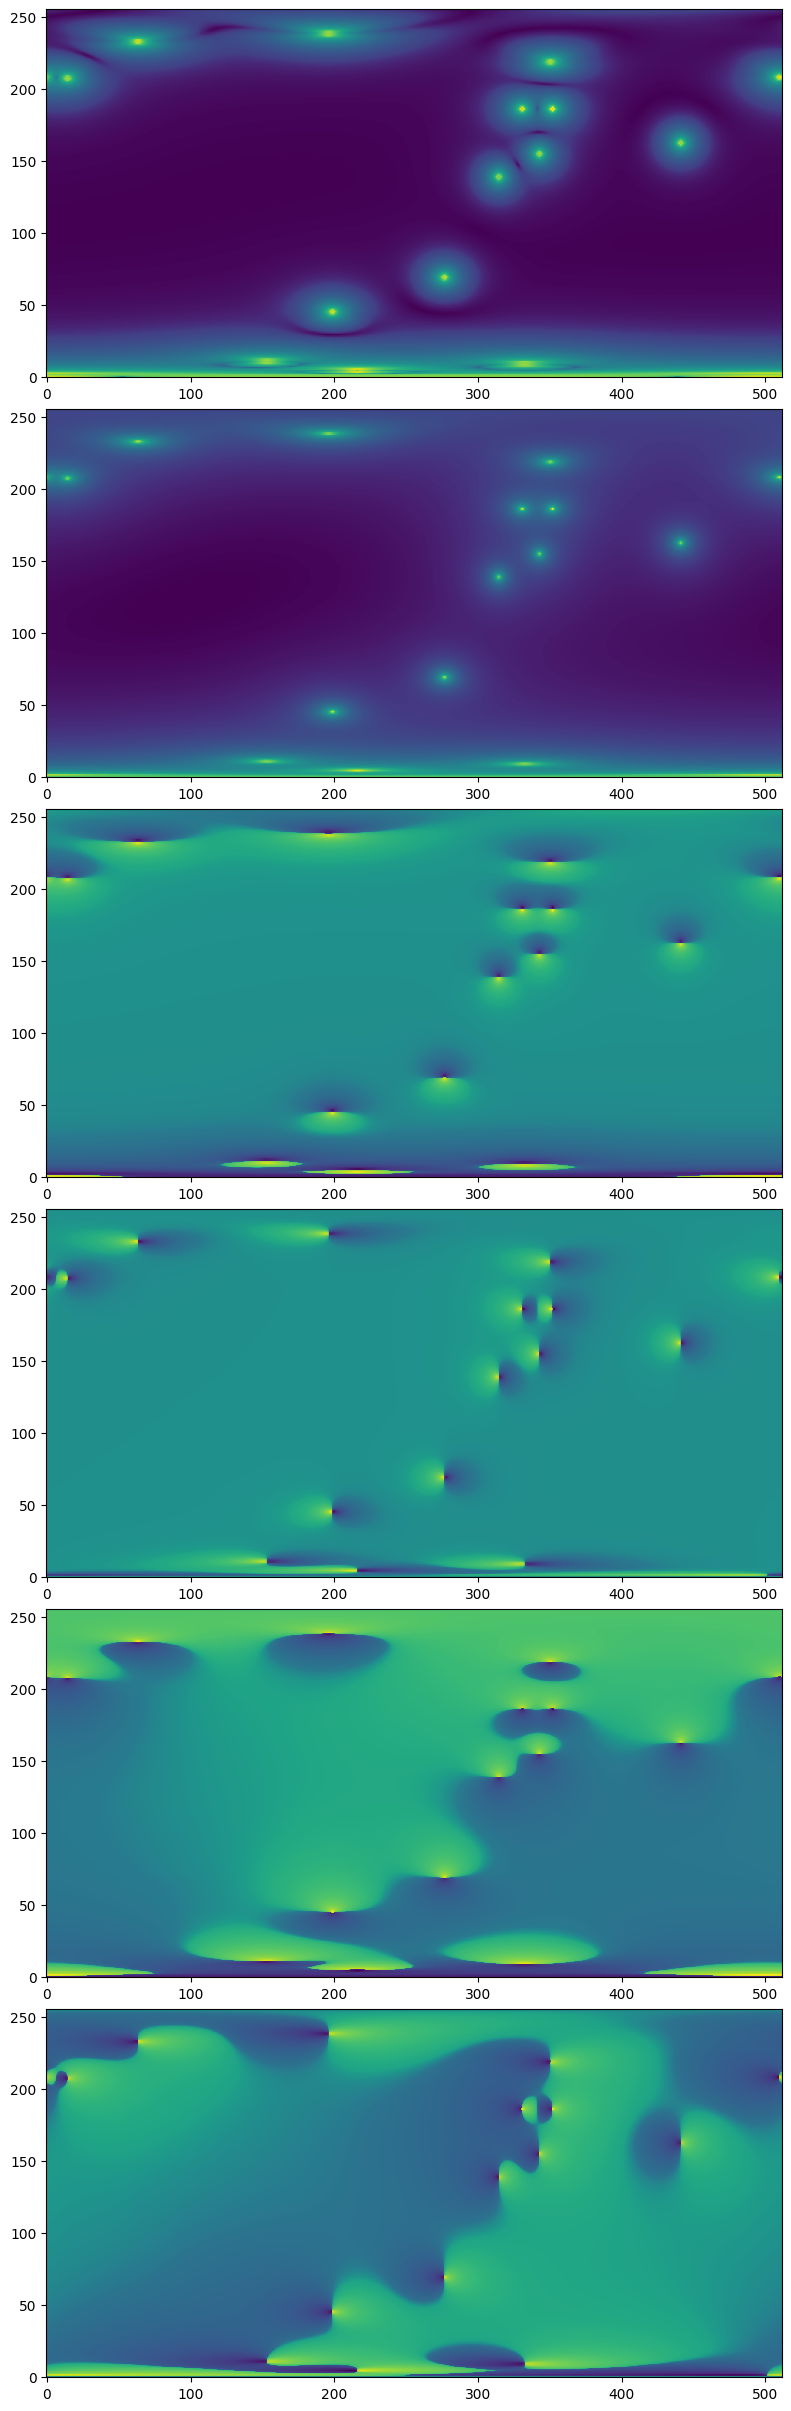

In [7]:
gradient = np.array(np.gradient(np.linalg.norm(plumes["force"], axis = 1).sum(0)))
figure, axes = plt.subplots(6, 1, figsize = (8, 24), layout = "constrained")
axes[0].imshow(np.linalg.norm(gradient, axis = 0), norm = "symlog", origin = "lower")
axes[1].imshow(np.linalg.norm(plumes["force"], axis = 1).sum(0), norm = "symlog", origin = "lower")
axes[2].imshow(gradient[0], norm = "symlog", origin = "lower")
axes[3].imshow(gradient[1], norm = "symlog", origin = "lower")
axes[4].imshow(plumes["force"].sum(0)[0], norm = "symlog", origin = "lower")
axes[5].imshow(plumes["force"].sum(0)[1], norm = "symlog", origin = "lower")

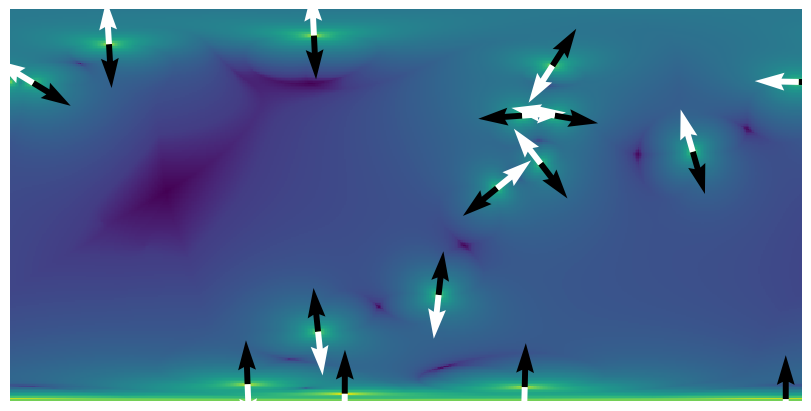

In [8]:
# image = np.linalg.norm(gradient, axis = 0)
# image = np.linalg.norm(plumes["force"], axis = 1).sum(0)
# image = np.abs(plumes["force"].sum(0)[0])*np.abs(plumes["force"].sum(0)[1])
# image = np.array([plume_index*plume for plume_index, plume in enumerate(plumes["nearest"])]).sum(0)
# image = (np.linalg.norm(plumes["force"], axis = 1)/np.linalg.norm(plumes["force"], axis = 1).sum(0)).max(0)
image = np.abs(plumes["force"].sum(0)[0]) + np.abs(plumes["force"].sum(0)[1])
figure, axis = plt.subplots(1, 1, figsize = (8, 4), layout = "constrained")
axis.pcolormesh(*coordinates[::-1], image, norm = "symlog")
for i in range(no_plumes):
    vector = np.where(plumes["nearest"][i], gradient, 0).sum((1, 2))
    vector /= np.linalg.norm(vector)
    axis.quiver(*plumes["coordinates"][i][::-1], *(-vector)[::-1], units = "xy", color = "black")
    axis.quiver(*plumes["coordinates"][i][::-1], *vector[::-1], units = "xy", color = "white")
    axis.axis("off")

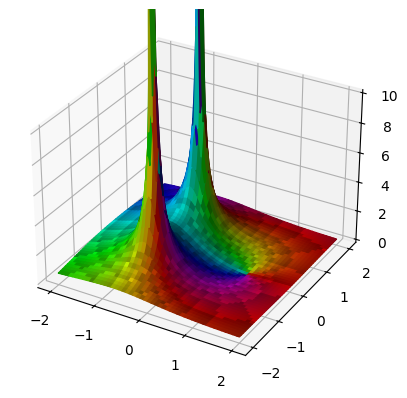

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

def saw_func(x, dx, a, b):
    x = x / dx - np.floor(x / dx)
    return a + (b - a) * x

def domain_coloring(mag, arg, phaseres=20):
    arg[arg < 0] += 2 * np.pi
    arg /= (2 * np.pi)
    blackp = saw_func(arg, 1 / phaseres, 0.75, 1)
    blackm = saw_func(np.log(mag), 2 * np.pi / phaseres, 0.75, 1)
    black = blackp * blackm
    H = arg
    S, V = np.ones_like(H), black
    return hsv_to_rgb(np.dstack([H, S, V]))

x = y = np.linspace(-2, 2, 200)
x, y = np.meshgrid(x, y)
z = x + 1j * y
f = (z - 1) / (z**2 + z + 1)
mag, arg = np.absolute(f), np.angle(f)
img = domain_coloring(mag, arg)

fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1, projection="3d")
ax2.plot_surface(x, y, mag, facecolors=img)
ax2.set_zlim([0, 10])
plt.show()

In [10]:
# image = np.linalg.norm(plumes, axis = 1).sum(0)
# image = plumes.sum(0)[1]
# image = plumes[6, 0]
image = plates.max(0)
image[grid.any(0)] = image.max()
figure, axis = plt.subplots(1, 1, figsize = (8, 4), layout = "constrained")
axis.imshow(image, norm = "symlog", origin = "lower")
axis.axis("off")
plt.show()

NameError: name 'plates' is not defined

NameError: name 'cells' is not defined

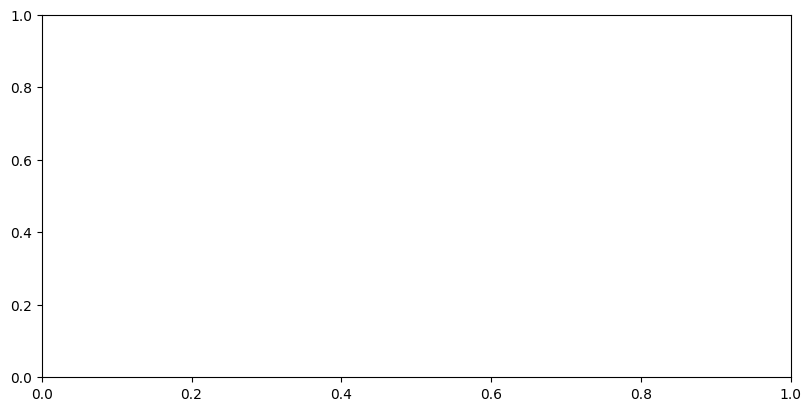

In [11]:
figure, axis = plt.subplots(1, 1, figsize = (8, 4), layout = "constrained")
axis.imshow(cells[0] - cells[1])
axis.axis("off")
plt.show()

In [ ]:
images = [*cells]
figure, axes = plt.subplots(len(images), 1, figsize = (8, 4*len(images)), layout = "constrained")
for axis_index, axis in enumerate(axes):
    axis.imshow(images[axis_index]*mask)
    axis.axis("off")
plt.show()

In [ ]:
images = [*coordinates, *cells]
figure, axes = plt.subplots(len(images), 1, figsize = (8, 4*len(images)), layout = "constrained")
for axis_index, axis in enumerate(axes):
    axis.imshow(images[axis_index]*mask)
    axis.axis("off")
plt.show()